# R-CNN

- This is simple implementation of the R-CNN, only for studies
- The objective here was not to get good results, only results
- I don't use the SVM to classifier (I've used dense layers with dropout)
- I don't use the regressor (I've used the selective search to get the predicts)

# Importing necessaries libraries

I'm using the contrib version of the cv2, then please install `pip install opencv-contrib-python`

In [127]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from helper_functions import ssearch, save_roi, read_annot, get_iou, nms, load_dataset

In [128]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Constants and directories

In [149]:
ROOT_PATH_DATASET = r"hole-detection/"
ANNOTATIONS_PATH = os.path.join(root_path_dataset, "annotations/")
IMAGES_PATH = os.path.join(root_path_dataset, "images/")
DATA_PATH = r"data/"
DETECTION_PATH = r"detections/"
POSITIVE_PATH = os.path.join(data_path, r"hole/")
NEGATIVE_PATH = os.path.join(data_path, r"background/")
SIZE = (224, 224)
MAX_PROPOSALS_REGION = 2000
BATCH_SIZE = 32
EPOCHS = 50

# Create the folders if doesn't exists

In [135]:
os.makedirs(POSITIVE_PATH, exist_ok=True)
os.makedirs(NEGATIVE_PATH, exist_ok=True)
os.makedirs(DETECTION_PATH, exist_ok=True)

# Selective Search

- This part is destinated to compute the positives/negatives regions of interest
- I saved locally for use in the train the base cnn

In [136]:
total_positive_count = 0
total_negative_count = 0
for e,annot in enumerate(os.listdir(ANNOTATIONS_PATH)):
    xml_path = os.path.join(ANNOTATIONS_PATH, annot)
    filename, gt_bbox_list = read_annot(xml_path)
    img_path = os.path.join(IMAGES_PATH, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Scalling the image
    img_resized = cv2.resize(img, SIZE)
    # Computing the scale
    scale_x = img_resized.shape[1] / img.shape[1]
    scale_y = img_resized.shape[0] / img.shape[0]
    
    results = ssearch(img_resized)
    
    print(f"{e} - {filename}")

    positive_count = 0
    negative_count = 0
    for gt_bbox in gt_bbox_list:
        # scalling
        gt_bbox[0] = int(np.round(gt_bbox[0]*scale_x))
        gt_bbox[1] = int(np.round(gt_bbox[1]*scale_y))
        gt_bbox[2] = int(np.round(gt_bbox[2]*scale_x))
        gt_bbox[3] = int(np.round(gt_bbox[3]*scale_y))
        for roi in results[:max_proposals_region]:
            iou_score = get_iou(gt_bbox, [roi[0], roi[1], roi[0]+roi[2], roi[1]+roi[3]])
            if iou_score >= 0.7: # Positive
                if positive_count < 30:  # Limit to the max 30 positives cases
                    img_roi = img_resized[roi[0]:roi[0]+roi[2], roi[1]:roi[1]+roi[3]]
                    save_roi(img_roi, os.path.join(positive_path, str(total_positive_count) + ".png"), SIZE)
                    total_positive_count += 1
                    positive_count += 1
            elif iou_score <= 0.3: # negative
                if negative_count < 30:  # Limit to the max 30 negatives cases
                    img_roi = img_resized[roi[0]:roi[0]+roi[2], roi[1]:roi[1]+roi[3]]
                    save_roi(img_roi, os.path.join(negative_path, str(total_negative_count) + ".png"), SIZE)
                    total_negative_count += 1
                    negative_count += 1

0 - 20-img03.png
1 - 22-img05.png
2 - 29-img12.png
3 - 30-img13.png
4 - 19-img02.png
5 - 24-img07.png
6 - 21-img04.png
7 - 10-img16.png
8 - 11-img17.png
9 - 13-img19.png
10 - 15-img21.png
11 - 17-img00.png
12 - 23-img06.png
13 - 14-img20.png
14 - 25-img08.png
15 - 12-img18.png
16 - 31-img14.png
17 - 27-img10.png
18 - 9-img15.png
19 - 18-img01.png
20 - 28-img11.png
21 - 26-img09.png


# LOAD DATASET

- In this part we'll use the positive matches and negatives match to train our base model

In [146]:
X, y = load_dataset(DATA_PATH, 4000)

## Encode the output

In [147]:
enc = OneHotEncoder().fit_transform(y.reshape(-1, 1))
y = enc.toarray()

## Split Dataset

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [140]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((703, 224, 224, 3), (79, 224, 224, 3), (703, 2), (79, 2))

# Basel Model

- I'm using the vgg16 (no top) and freezing the cnn layers

In [141]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [142]:
# Loading VGG
vgg = tf.keras.applications.vgg16.VGG16(include_top=False, 
                                        weights='imagenet', 
                                        input_tensor=None, 
                                        input_shape=(224, 224, 3), 
                                        pooling=None, 
                                        classes=1000)

In [143]:
inputs = keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = vgg(x, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              256911

## Compile model

In [144]:
optim = Adam(1e-4)
loss = CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optim,
              loss=loss,
              metrics=["accuracy"])

## Callbacks

In [145]:
checkpoint = ModelCheckpoint("best_model.h5", 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

## Train Model

In [148]:
model.fit(X_train,
          y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_split=0.1,
          callbacks=[checkpoint, early],
          verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.9182 - accuracy: 0.8370
Epoch 1: val_loss improved from inf to 0.61125, saving model to best_model.h5
20/20 [==============================] - 16s 561ms/step - loss: 0.9182 - accuracy: 0.8370 - val_loss: 0.6112 - val_accuracy: 0.8169
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8718
Epoch 2: val_loss improved from 0.61125 to 0.28903, saving model to best_model.h5
20/20 [==============================] - 7s 352ms/step - loss: 0.3168 - accuracy: 0.8718 - val_loss: 0.2890 - val_accuracy: 0.8873
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.8576
Epoch 3: val_loss did not improve from 0.28903
20/20 [==============================] - 5s 272ms/step - loss: 0.2553 - accuracy: 0.8576 - val_loss: 0.4164 - val_accuracy: 0.8310
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.8845
Epoch 4: val_loss did n

## Evaluate Model (Classification)

In [155]:
# load the best weights from the training
model = keras.models.load_model("best_model.h5")
print(model.evaluate(X_test, y_test, verbose=0))

[0.14740948379039764, 0.9240506291389465]


# Testing the R-CNN

- Note that I'm using only the Select Search to predict the bounding boxes

26-img09.png
22-img05.png
21-img04.png
10-img16.png
23-img06.png
13-img19.png
31-img14.png
18-img01.png
14-img20.png
30-img13.png
28-img11.png
24-img07.png
11-img17.png
25-img08.png
15-img21.png
9-img15.png
27-img10.png
29-img12.png
20-img03.png
17-img00.png
12-img18.png
19-img02.png


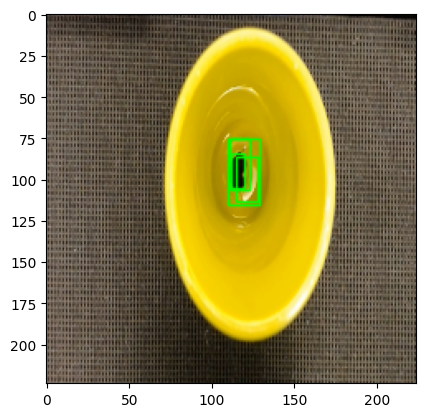

In [156]:
predicted_bboxes = []
confidences = []
threshold = 0.5
img_filenames = os.listdir(images_path)
for img_filename in img_filenames:
    print(img_filename)
    img_path = os.path.join(images_path, img_filename)
    img = cv2.imread(img_path)
    img = cv2.resize(img, SIZE)
    results = ssearch(img)
    for i, result in enumerate(results[:max_proposals_region]):
        x, y, w, h = result
        img_cutted = img[x:x+w, y:y+h]
        img_resized = cv2.resize(img_cutted, SIZE, interpolation = cv2.INTER_AREA)
        img_resized = np.expand_dims(img_resized, axis=0)
        out = model.predict(img_resized, verbose = 0)
        predicted_bboxes.append([x, y, x+w, y+h])
        confidences.append(out[0][1])
    predicted_bboxes, scores = nms(predicted_bboxes, confidences, threshold)
    for bbox, score in zip(predicted_bboxes, scores):
        if score > 0.5: ## only predict if the score is more than 50%
            img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1, cv2.LINE_AA)
    plt.imshow(img)
    plt.savefig(os.path.join(DETECTION_PATH, img_filename))
    
    predicted_bboxes = []
    confidences = []